# Assignment #4 - Reinforcement Learning

### <font color="red"> DUE: Nov 30 (Monday) 11:00 pm </font>  

<font color="blue"> Zachary Hamilton </font>

# I. Overview

The objective of this assignment was to 

# II. Problems 



## 2D Marble Control

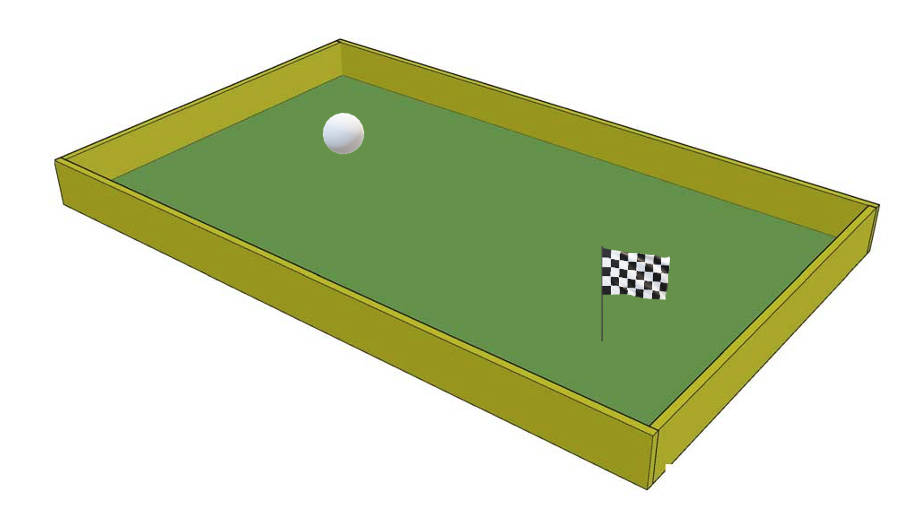

#### STEPS for 2D Marble

1. [II Problems] First, build 2D marble class by extending the Marble class from the class note. 
2. [II Problems] Explain the environment.
3. [III Methods] Build your own RLAgent class to solve the problem.
4. [III Methods] Explain your RLAgent (with a neural network function approximator)
5. [IV Results]  Discuss the results 



## Mountain Car


<img src="https://gym.openai.com/videos/2019-10-21--mqt8Qj1mwo/MountainCarContinuous-v0/poster.jpg" data-video-type="video/mp4" data-video-source="https://gym.openai.com/videos/2019-10-21--mqt8Qj1mwo/MountainCarContinuous-v0/original.mp4">



#### STEPS for Mountain Car

1. [II Problems] Learn the classic mountain car problem and explain it
2. [II Problems] Learn how to use the OpenAI Gym "MountainCarContinuous-v0" environment ([OpenAI Gym MountainCarContinuous-v0](https://gym.openai.com/envs/MountainCarContinuous-v0/))
  2.a. Following the link, by clicking the document tab, you can learn how to install and use openai.gym
3. [III Methods] Build your own RLAgent class to solve the problem.
4. [III Methods] Explain your RLAgent (with a neural network function approximator)
5. [IV Results]  Discuss the results 


# III. Methods

- Decide your TD learning approach: SARSA or Q-learning? 
- Describe your neural network function approximator (how many hidden unites? why?).
- Describe your approach and the reason why you select it.
- Explain your codes.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display as ipd  # for display and clear_output
import collections
from copy import deepcopy as copy
import math
import gym
from gym import spaces
from gym.utils import seeding
from util import Standardizer

In [2]:
class Marble():
    """ 2d marble problem
        
        states: x, dx
        action: action [-1., 0.],[1., 0.],[0., -1.],[0., 1.]


        |            ___                     |
        |___________|///|____G_______________|
                    <- ->
    """

    def __init__(self,goal=[5,5], **params):
        # len(state) + action (1)
        self.n_state = 2
        self.n_action = 2
        self.Goal = goal
        self.bound = params.pop('bound', [0, 10, -5, 5])

        self._st_range = np.array(([self.bound[0], self.bound[2],-1,0],[self.bound[1], self.bound[3], 1,0],[self.bound[0], self.bound[2],0,-1],[self.bound[1], self.bound[3],0, 1]))        
        self.goal_width = 1
        self._s = [[0, 0],[0,0]]

    def init(self, start=None):
        if start is not None:
            self._s = start
        else: 
            self._s = [[np.random.randint(self.bound[0], self.bound[1]), 0.],[np.random.randint(self.bound[0], self.bound[1]), 0.]]
        return self._s
       
    def get_random_action(self):
        return float(np.random.randint(3) -1) # discrete action

    def get_bound_act(self, a):
        if a[0] > 1:
            return 1
        elif a[0] < -1:
            return -1
        else:
            return a[0]

    def next(self, a) :
        s = self._s
        if isinstance(a, collections.Iterable):
            a = a[0]
        s1 = copy(s)
        dT = 0.1
        s1[0][0] += dT * s[1][0]  
        s1[1][0] += dT * ( 2*a - 0.2 * s[1][0] )
        s1[0][1] += dT * s[1][1]  
        s1[1][1] += dT * ( 2*a - 0.2 * s[1][1] )
        # adjust velocity when outside of the track
        if s1[0][0] < self.bound[0]:
            s1[0][0]  = self.bound[0]
            s1[1][0]= 0
        elif s1[0][0] > self.bound[1] :
            s1[0][0]  = self.bound[1]
            s1[1][0]= 0
        elif s1[0][1] < self.bound[0]:
            s1[0][1]  = self.bound[0]
            s1[1][1]= 0
        elif s1[0][1] > self.bound[1] :
            s1[0][1]  = self.bound[1]
            s1[1][1]= 0  
        # clipping the velocity
        s1[1][0] = np.clip(s1[1][0], self._st_range[0, 1],
                               self._st_range[1, 1])
        s1[1][1] = np.clip(s1[1][1], self._st_range[0, 1],
                               self._st_range[1, 1])
        self._s =  s1
        return self.get_reward(s, s1, a)

    def get_cur_state(self):
        return self._s

    def get_reward(self,s,s1,a):
        #print(np.array([s1[0][0],s1[1][0]])- np.array(self.Goal))
        return 1 if abs(np.array([s1[0][0],s1[0][1]]) - np.array(self.Goal))[0] < self.goal_width and abs(np.array([s1[0][0],s1[0][1]]) - np.array(self.Goal))[1] < self.goal_width else 0

    def get_state_range(self):
        return self._st_range

    def get_actions(self):
        return np.array([[-1., 0.],[1., 0.],[0., -1.],[0., 1.]])

    def get_action_index(self, action):
        return np.where(np.array([-1, 0, 1]) == action)[0][0]

    def draw_trajectory(self, smplX):
        if smplX.shape[1] == 1: return
        plt.plot(smplX[:,0],smplX[:,1])
        plt.axis([self.bound[0], self.bound[1],-5,5])
        plt.plot(smplX[0,0],smplX[0,1],'go')
        plt.plot(self.Goal,0,'ro')
        # draw a goal region
        plt.fill_between([self.Goal-self.goal_width, self.Goal+self.goal_width],
                         [-5,-5], [5,5],
                         color="red", alpha=0.3)
        plt.xlabel("s") 
        plt.ylabel("s dot")

In [3]:
class RLagent(Marble):
    def __init__(self,env,r=0.01,nInputs = 4,nOutputs = 1,nSamples = 1,nHiddens = 5):
        self.env=env
        self.rhoh = self.rhoo = r
        self.rh = self.rhoh / (nSamples*nOutputs)
        self.ro = self.rhoo / (nSamples*nOutputs)
        self.V = 0.1*2*(np.random.uniform(size=(nInputs+1,nHiddens))-0.5)
        self.W = 0.1*2*(np.random.uniform(size=(1+nHiddens,nOutputs))-0.5)
        self.fig = plt.figure(figsize=(8, 8))
        self.stdX = Standardizer(self.env.get_state_range())
    def addOnes(self,A):
        return np.insert(A, 0, 1, axis=len(np.array(A).shape)-1)

    def forward(self,X):
        X = self.stdX.standardize(X)
        # Forward pass on training data
        X1 = self.addOnes(X)
        Z = np.tanh(X1 @ self.V)
        Z1 = self.addOnes(Z)
        Y = Z1 @ self.W
        return Y, Z

    def as_array(self,A):
        A = np.array(A)
        if len(A.shape) == 1:
            return A.reshape((1, -1))
        return A

    def backward(self,error, Z, X):
    
        ### make sure the array shapes
        X = self.as_array(X)
        Z = self.as_array(Z)
        E = self.as_array(error)
    
        Z1 = self.addOnes(Z)
        X1 = self.addOnes(X)

        # Backward pass - the backpropagation and weight update steps
        dV = self.rh * X1.T @ ( ( E @ self.W[1:,:].T) * (1-Z**2))
        dW = self.ro * Z1.T @ E
        return dV, dW


    def epsilon_greedy(self, epsilon, s,n_a):
        if np.random.uniform() < epsilon:
            return np.random.randint(n_a) - 1
        else:
            Q, _ = self.forward(np.hstack((np.tile(s, (2,1)), env.get_actions())))
            max_as = np.where(Q == np.max(Q))[0] - 1 # index to action value
            return np.random.choice(max_as)
    def use(self,k=300,n=4,steps=500,g=.9,verb=False,epsilon=1,final=0.1):
        K = k 
        n_actions = n 
        max_steps = steps
        gamma = g
        verbose = verb
        epsilon = epsilon
        final_epsilon = final
        epsilon_decay =  np.exp(np.log(final_epsilon) / K)
        rtrace = []
        etrace = [epsilon]
        for j in range(K):

            if verbose: print("\tepisode #", j, "   ",end="")
            env.init([[3,3],[0,0]]) #[float(np.random.randint(-5, 5, 1)), 0])
            s = env.get_cur_state()
            # selection an action
            a = env.get_actions()[self.epsilon_greedy(epsilon, s,n_actions)]

            rewards = []
            trace = np.array(s)
            for step in range(max_steps):
                if verbose: print("\tstep #", step, "   ",end="")
                # move
                r1 = env.next(a)
                s1 = env.get_cur_state()
                a1 = env.get_actions()[self.epsilon_greedy(epsilon, s1,n_actions)]
                rewards.append(r1)
                trace = np.vstack((trace, s1))
                # update neural networks
                Q1, _ = self.forward(np.hstack((s1, [a1,a1])))  # output of neural network is Q for next state
                Q, Z = self.forward(np.hstack((s, [a,a])))  # output of neural network is Q for next state
                error = r1 + gamma * Q1 - Q  # use action value as index by adding one
                dV, dW = self.backward(error, Z, np.hstack((s, [a,a])))
                self.V += dV
                self.W += dW

                s = s1
                a = a1
        
            epsilon *= epsilon_decay
            etrace.append(epsilon)


            if verbose: print("Done (", np.sum(rewards), ")", step)

            rtrace.append(np.sum(rewards))

            last_plot = (j == K-1)
    
            if j % 10 == 0 or last_plot:
                plt.clf()
                self.fig.add_subplot(221)
                plt.plot(rtrace, "b-")
                plt.ylabel("sum of rewards")

                self.fig.add_subplot(222)
                plt.plot(etrace, "-")
                plt.ylabel("p(random action), $\epsilon$")

                # contour plot for Q
                self.fig.add_subplot(223)
                xs, ys = np.meshgrid(np.linspace(0, 10, 100), np.linspace(0, 10, 100))
                X = np.vstack((xs.flat, ys.flat)).T

                Q = np.array([self.forward(np.hstack((x, a)))[0] for a in env.get_actions() for x in X])
                maxQ = np.max(Q.reshape((4, -1)), axis=0)
                cs = plt.contourf(xs, ys, maxQ.reshape(xs.shape))
                plt.colorbar(cs)
                plt.text(env.Goal[0], env.Goal[1],'G')
                plt.ylabel("max Q")

                # plot traces
                self.fig.add_subplot(224)
                #print(trace)
                plt.plot(trace[:, 0], trace[:, 1], "k-")
                plt.fill_between([env.Goal[0]-1, env.Goal[0]+1], [6, 6],[4, 4], color='red', alpha=0.3)
                plt.title("trace of last episode")
                plt.xlim([0, 10])
                plt.ylim([0, 10])

                plt.suptitle(''.join(["Episode ",str(j)]))
                plt.tight_layout(rect=[0, 0.03, 1, 0.95])
                plt.draw()

                ipd.clear_output(wait=True)
                ipd.display(self.fig)
        ipd.clear_output(wait=True)

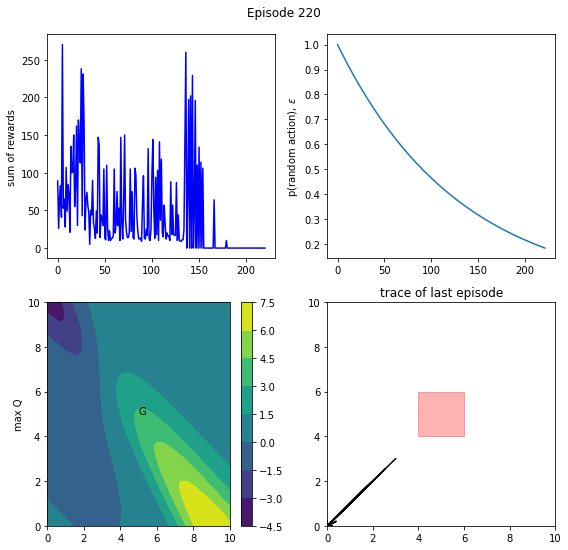

KeyboardInterrupt: 

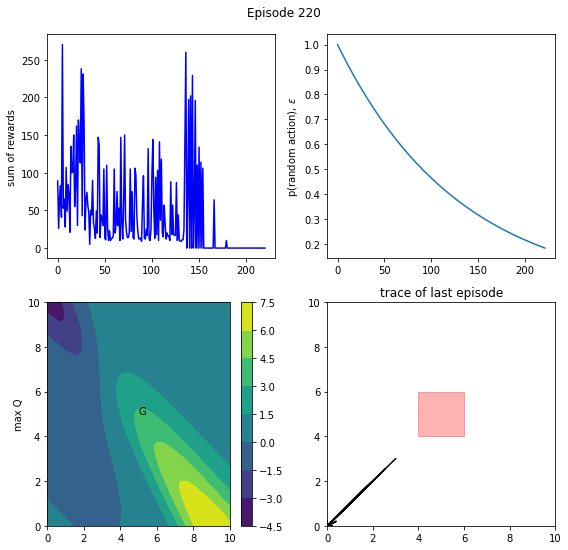

In [4]:
env=Marble()
agent=RLagent(env)
agent.use()

In [5]:
env=gym.make('MountainCarContinuous-v0')
class MountainAgent:
    def __init__(self,env,alpha=0.2,gamma=.9,epsilon=.8):
        self.env=env
        self.alpha=alpha
        self.gamma=gamma
        self.epsilon=epsilon
        self.num_states = (env.observation_space.high - env.observation_space.low)*np.array([10, 100])
        self.num_states = np.round(self.num_states, 0).astype(int) + 1
        self.Q=np.random.uniform(low = -1, high = 1, 
                          size = (self.num_states[0], self.num_states[1], 
                                  3))
    def epsilon_greed(self, epsilon, s):
        if np.random.random() < 1 - epsilon:
            action = np.argmax(self.Q[s[0], s[1]]) 
        else:
            action = np.random.randint(0, 3)
        return action
    def use(self,nitter):
        for _ in range(nitter):
            env.reset()
            done = False
            s=env.reset()
            s=(s - env.observation_space.low)*np.array([10, 100])
            s=np.round(s, 0).astype(int)
            if _%100 == 0 and _!=0:
                ipd.clear_output(wait=True)
                print('Episode: ',_)
            while done != True:
                if _ > nitter - 5:
                    env.render()
                a=[self.epsilon_greed(self.epsilon,s)]
                s1,r,done,x=env.step(a) # take a random action
                s1=(s1 - env.observation_space.low)*np.array([10, 100])
                s1=np.round(s1, 0).astype(int)            
                self.Q[s[0],s[1],a]+=self.alpha*(r+self.gamma*np.max(self.Q[s1[0],s1[1]])-self.Q[s[0],s[1],a])
                s=s1
            env.close()

In [6]:
mAgent=MountainAgent(env)
mAgent.use(5000)

Episode:  200


KeyboardInterrupt: 

# IV - Results

- Describe the choice of your hyper-parameters for $\gamma$, $\epsilon$, the learning rates $\rho$'s, and the number of hiddend units (or other NN hyper-parameters). 
  - Run experiments to find good hyper-parameters
  - Show the experimental outputs to show the process of your selection
- Visualize the results and explain outputs 
  - Run the codes and tell me what you observe
  - Add more visualizations to enrich your explanation.

# V. Conclusions

Discuss the challenges or somethat that you learned. 
If you have any suggestion about the assignment, you can write about it. 

# VI. References
gkhayes. “Use Q-Learning to Solve the OpenAI Gym Mountain Car Problem.” Gist, 2018, gist.github.com/gkhayes/3d154e0505e31d6367be22ed3da2e955. 

# Extra Credit

You will be qualified to earn an extra credit when you solve both problems with complete experimental results and discussions, following the bullets in results section for both. 



## Grading

For this assignment, the grading rubric is a bit different. Please check it carefully. 


points | | description
--|--|:--
5 | Overview| states the objective and the appraoch 
25 | Problems | 
 |10| 2D Marble Class
 | 5| Explanation of problem and class implementation
 | 5| Explanation of mountain car problem
 | 5| explanation of the codes to use MountainCarContinuous-v0 from OpenAI Gym
25 | Methods | 
 |10| RLAgent1 for the first problem
 | 5| Explanation of the RLAgent1
 | 5| RLAgent2 for the second problem
 | 5| Explanation of the RLAgent2
40 | Results 
 | 5| Reports the selected parameters 
 |10| Experimental outputs that show the choice of parameters. How do you choose them?
 | 5| Visualization of learning and learned agent
 |10| Observations and analysis of learning results and plots
 |10| Results analysis (following the above four rubric criteria) for the second problem
5 | Conclusions 
